# TP53 Methods - Analyzing the cis effects of TP53 mutation on p53

Our first step was to determine the ways in which TP53 mutation affects the protein that the TP53 gene codes for: p53.

### Standard imports, including CPTAC package

In [28]:
import pandas as pd
import numpy as np
import re
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import cptac
CPTAC = cptac.Endometrial()

### Set up initial dataframes and variables

In [30]:
gene='TP53'
somatic = CPTAC.get_mutations()
clinical = CPTAC.get_clinical()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()
transcriptomics = CPTAC.get_transcriptomics()

# A list of mutations present in the hotspot according to our Hotspot3D output (see Data_Files/HotSpot3DOutput.xlsx)
hotspot_mutations = ['p.P250L', 'p.R248W', 'p.S241C', 'p.S241del','p.K164E', 'p.R249S', 'p.R273H', 'p.R282W',
                    'p.S127Y', 'p.G244D', 'p.A159P']

mutated_hotspot = somatic.loc[(somatic['Location'].isin(hotspot_mutations))]
mutated_hotspot = mutated_hotspot.loc[(mutated_hotspot['Gene'] == 'TP53')]

# Get a list of patient identifiers for those who have mutations in the hotspot
patient_ids = clinical['Patient_ID']
hotspot_patients = mutated_hotspot.join(patient_ids)['Patient_ID']
hotspot_patients

Sample_ID
S001    C3L-00006
S006    C3L-00098
S008    C3L-00137
S016    C3L-00358
S020    C3L-00449
S031    C3L-00905
S071    C3N-00339
S072    C3N-00340
S082    C3N-00836
S096    C3N-01346
S097    C3N-01349
Name: Patient_ID, dtype: object

### Determine the number of patients with TP53 mutations inside and outside of the hotspot

In [32]:
p53_mutated

,Gene,Mutation,Location
Sample_ID,,,
S001,TP53,Missense_Mutation,p.R248W
S006,TP53,Missense_Mutation,p.S241C
S008,TP53,Missense_Mutation,p.S127Y
S009,TP53,Nonsense_Mutation,p.R196*
S016,TP53,Missense_Mutation,p.K164E
S020,TP53,Missense_Mutation,p.G244D
S022,TP53,Nonsense_Mutation,p.R213*
S031,TP53,In_Frame_Del,p.S241del
S041,TP53,Nonsense_Mutation,p.W146*


In [34]:
print("Mutations inside hotspot: " + str(len(hotspot_patients)))
p53_mutated = somatic.loc[somatic['Gene'] == 'TP53']

# Some people have more than one mutation so we need to grab the unique values
num_mutated = len(set(p53_mutated.index)) 
print("Total number of patients with mutations: " + str(num_mutated))

Mutations inside hotspot: 11
Total number of patients with mutations: 21


# TP53 cis effects

## Proteomic analysis

First we analyze the protein expression (proteomics) of p53 when TP53 is mutated

TP53 proteomics hotspot mutation vs wildtype: 1.831110996008358e-13
Non-hotspot TP53 mutation vs wildtype 8.561261113409393e-06
TP53 proteomics all mutation vs wildtype: 3.9910719738656374e-07
TP53 truncation mutations vs wildtype: 0.0824918155899048


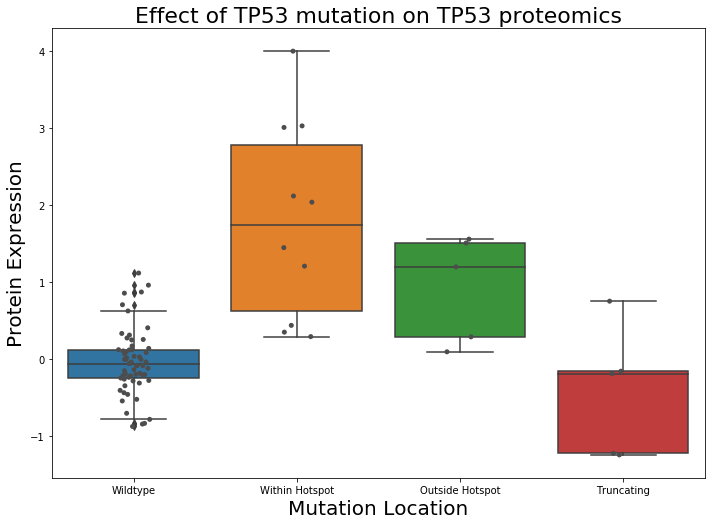

In [4]:
protein = 'TP53'
# 1.  Merge the mutation status of P53 and the proteomics data of P53
p53_mutations_protein = CPTAC.compare_mutations(proteomics, protein, gene)
p53_mutations_protein = p53_mutations_protein.replace({'Mutation': {'Frame_Shift_Del': 'Truncation',
                                      'Frame_Shift_Ins': 'Truncation',
                                      'Nonsense_Mutation': 'Truncation'}})

# 2. Set up a new column for mutations that are within the hotspot
p53_mutations_protein['Within_Hotspot'] = 'Outside Hotspot'
p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = 'Within Hotspot'
p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype_Tumor', 'Within_Hotspot'] = 'Wildtype'
p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Truncation', 'Within_Hotspot'] = 'Truncating'

# 3. Select for tumor samples only
p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Sample_Status'] == 'Tumor'].dropna(axis=0)

# 4.  Make two new DFs, one for people with a hotspot mutation, one for all the wildtype cancer patients.
mutated_htspt = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Within Hotspot']
p53_non_htspt = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Outside Hotspot']
trunc = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Truncating']
wt = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Wildtype']

# 5. ttest for proteomics of TP53 between wildtype cancer and hotspot mutation
ttest = scipy.stats.ttest_ind(mutated_htspt[protein], wt[protein])
print(protein + " proteomics hotspot mutation vs wildtype: " + str(ttest[1]))

# 6. Perform a ttest for non-hotspot mutations vs wildtype
ttest = scipy.stats.ttest_ind(p53_non_htspt[protein], wt[protein])
print("Non-hotspot TP53 mutation vs wildtype " + str(ttest[1]))

# 7. Repeat for all mutations vs wildtype cancer
all_mutated = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] != 'Wildtype']
ttest = scipy.stats.ttest_ind(all_mutated[protein], wt[protein])
print(protein + " proteomics all mutation vs wildtype: " + str(ttest[1]))

# 8. Repeat for truncating mutations vs wildtype cancer
ttest = scipy.stats.ttest_ind(trunc[protein], wt[protein])
print(protein + " truncation mutations vs wildtype: " + str(ttest[1]))

# 8. Plot the data
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = p53_mutations_protein, x = 'Within_Hotspot', order = ['Wildtype', 'Within Hotspot', 'Outside Hotspot', 'Truncating'], y = protein, ax = ax)
boxplt = sns.stripplot(data = p53_mutations_protein, x = 'Within_Hotspot', y = protein, order = ['Wildtype', 'Within Hotspot', 'Outside Hotspot', 'Truncating'], jitter = True, color = '.3')
boxplt.set_xlabel('Mutation Location', fontsize='20')
boxplt.set_ylabel('Protein Expression', fontsize='20')
boxplt.set_title("Effect of " + gene + " mutation on " + protein + " proteomics", fontsize='22')
plt.show()

## Phosphoproteomic analysis

Now we look at the phosphorylation of p53 when TP53 is mutated

TP53 hotspot mutation and TP53-S315: 3.0705238405493975e-16
All TP53 mutation and TP53-S315: 1.3521548356836731e-05
Non-hotspot TP53 mutation and TP53-S315: 0.5263810882144033
TP53 hotspot mutation and TP53-T150: 0.14193479299996514
All TP53 mutation and TP53-T150: 0.2648826991209718
Non-hotspot TP53 mutation and TP53-T150: 0.797403871224218


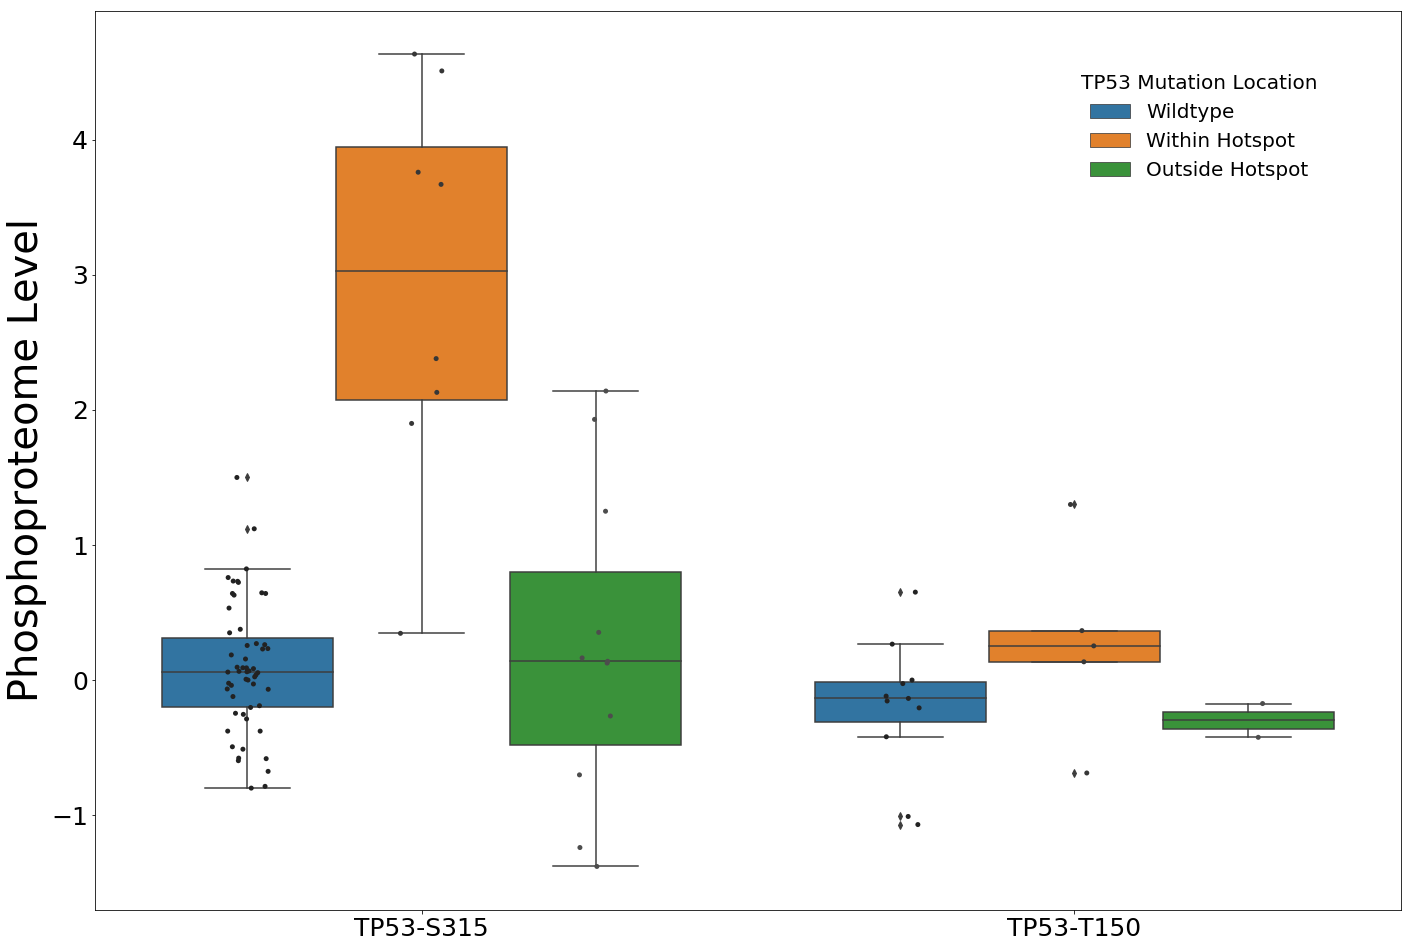

In [5]:
protein = 'TP53-'
pattern = re.compile(protein)

# 1. Create a dataframe combining phosphosite data with TP53 mutation status; select for tumor samples
p53_mutations_protein = CPTAC.compare_mutations(phos, protein, gene)
p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Sample_Status'] == 'Tumor'].drop('Sample_Status', axis=1)

# 2. Make a new column for mutation location relative to hotspot
p53_mutations_protein['Within_Hotspot'] = 'Outside Hotspot'
p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = 'Within Hotspot'
p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype_Tumor', 'Within_Hotspot'] = 'Wildtype'
p53_mutations_protein.drop('Mutation', axis=1)

# 3. Begin constructing a dataframe for plotting, starting only with the mutation location
plotdf = p53_mutations_protein[['Within_Hotspot']]

# 4. Loop through each phosphosite to check for significance:
for site in p53_mutations_protein.columns:
    if (site != 'Within_Hotspot' and site != 'Mutation'):
        sitedf = p53_mutations_protein[[site, 'Within_Hotspot']].dropna(axis=0)
        tp53_phos_htspt = sitedf.loc[sitedf['Within_Hotspot'] == 'Within Hotspot']
        tp53_phos_non_htspt = sitedf.loc[sitedf['Within_Hotspot'] == 'Outside Hotspot']
        tp53_phos_wt = sitedf.loc[sitedf['Within_Hotspot'] == 'Wildtype']
        tp53_phos_all_mut = sitedf.loc[sitedf['Within_Hotspot'] != 'Wildtype']
        
        #Perform a ttest for hotspot vs wildtype
        ttest = scipy.stats.ttest_ind(tp53_phos_htspt[site], tp53_phos_wt[site])
        print("TP53 hotspot mutation and " + site + ": " + str(ttest[1]))
        plotdf = plotdf.join(p53_mutations_protein[site])
        
        #Perform a ttest for all mutations vs wildtype
        ttest = scipy.stats.ttest_ind(tp53_phos_all_mut[site], tp53_phos_wt[site])
        print("All TP53 mutation and " + site + ": " + str(ttest[1]))
        
        #Perform a ttest for non-hotspot mutations vs wildtype
        ttest = scipy.stats.ttest_ind(tp53_phos_non_htspt[site], tp53_phos_wt[site])
        print("Non-hotspot TP53 mutation and " + site + ": " + str(ttest[1]))
        

# 5. Plot the sites
plotdf = pd.melt(plotdf, id_vars = ['Within_Hotspot'], var_name = 'Site', value_name = 'Phos')
plotdf = plotdf.dropna(axis = 0)
            
a4_dims = (23.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)

#Create the plot
boxplt = sns.boxplot(x='Site', y='Phos', hue='Within_Hotspot', hue_order = ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], data=plotdf)
boxplt = sns.stripplot(data=plotdf, x='Site', y='Phos', hue='Within_Hotspot', hue_order = ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Phosphoproteome Level', fontsize='40')
boxplt.tick_params(labelsize='25')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:3], ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], title='TP53 Mutation Location', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
boxplt.get_legend().set_bbox_to_anchor((0.95, 0.95, 0, 0))